# <center>IRIS - Multiclass Classification with Tensorflow and Keras using a Multilayer Perceptron (MLP)</center>
<center><img src="keras-tensorflow-logo.jpg"></center>

In this notebook, **we will illustrate multi-class classification of the IRIS dataset using a Multilayer Perceptron (MLP) (also called an ANN).** This dataset will be downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data)

The IRIS dataset is a popular dataset, used in several examples with the `scikit-learn` library. The dataset had 150 records for 3 Iris flower species (Iris-setosa, Iris-versicolor and Iris-virginica). Each species is classified using 4 features - sepal length, sepal width, petal length and petal width. There are 50 records per species of flower. A complete description of the dataset is provided [here](https://archive.ics.uci.edu/ml/datasets/iris). 

**NOTE:** Strictly speaking, we need not use deep-learning techniques for classification of such simple, structured datasets. Traditional techniques (i.e. classifiers from the `scikit-learn` library) should suffice. However, using such a dataset serves as a good starter point for someone coming over to deep learning from a traditional machine learning background, where they have been using `scikit-learn` and `XGBoost` libraries.

In this notebook we will first develop a MLP using Tensorflow. Thereafter the same network architecture will be developed using Keras (running with Tensorflow backend). I expect to see similar performance out of both networks.

In [1]:
%reload_ext autoreload
%autoreload 2

# imports & tweaks
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, time

# tweaks for numpy & plotting libraries
float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(threshold=np.inf, suppress=True, precision=4, linewidth=2048)

plt.style.use("seaborn-colorblind")
plt.rcParams["figure.figsize"] = (8, 6)
sns.set_style("darkgrid")
#sns.set_context("talk")
sns.set_context(context='notebook', font_scale=1.25)
sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

# NOTE: Always use a seed for random number generators, so you get same results across runs
# you can use any number as the seed 
seed = 101
np.random.seed(seed)

## Loading & Pre-processing the Images
We will download the IRIS dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data). We will use the Pandas library to pre-process the data. The downloaded dataset is in CSV format, sorted by the species columns - first 50 records are for Iris-setosa, next 50 for Iris-versicolor and last 50 for Iris-virginical species. The features are ordered (left to right) as `sepal length, sepal width, petal length & petal width`. The dataset does not have column headers - we will provide these too. 

In [2]:
import pandas as pd

# tweaks for pandas
pd.set_option('display.notebook_repr_html',True)
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', 1024)
pd.set_option('display.float_format', float_formatter)

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

# helper function to download the data from UCI ML repository URL
def load_data():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
    iris_df = pd.read_csv(url, header=None, names=col_names)
    species = np.unique(iris_df['species'])
    return iris_df, species

In [3]:
iris_df, species = load_data()
# select 20 random records & display
indexes = np.random.randint(0, len(iris_df), 20)
#iris_df.head()  # display first 5
iris_df.iloc[indexes,:]

,sepal_length,sepal_width,petal_length,petal_width,species
95,5.7000,3.0000,4.2000,1.2000,Iris-versicolor
11,4.8000,3.4000,1.6000,0.2000,Iris-setosa
81,5.5000,2.4000,3.7000,1.0000,Iris-versicolor
70,5.9000,3.2000,4.8000,1.8000,Iris-versicolor
63,6.1000,2.9000,4.7000,1.4000,Iris-versicolor
87,6.3000,2.3000,4.4000,1.3000,Iris-versicolor
75,6.6000,3.0000,4.4000,1.4000,Iris-versicolor
...,...,...,...,...,...
5,5.4000,3.9000,1.7000,0.4000,Iris-setosa
140,6.7000,3.1000,5.6000,2.4000,Iris-virginica


In [4]:
print(species)

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


The following pre-processing steps will be applied:
* The `species` column is categorical (text) - we will encode/map to numeric values using following mapping `{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}`
* The data is sorted by `species` columns (i.e. first 50 rows are for Iris-setosa, next 50 for Iris-versicolor and last 50 for Iris-virginica) - we will shuffle the data so that train & test sets are randomly picked
* The features (sepal_length, sepal_width, petal_length & petal_width) will be standard scaled & labels (species) will be one-hot encoded to 3 columns (corresponding to 3 output classes/species)
These transformations are applied across several of the following cells.

In [5]:
# helper functions to encode/decode columns
labels2code_map = {j:i for i, j in enumerate(species)}
code2labels_map = {i:j for i, j in enumerate(species)}
print(labels2code_map)
print(code2labels_map)

def encode_array(arr):
    # convert labels to code
    encoder = np.vectorize(lambda label : labels2code_map[label])
    return encoder(arr)
    
def decode_array(arr):
    # convert code to labels
    decoder = np.vectorize(lambda code : code2labels_map[code])
    return decoder(arr)

encoded_array = encode_array(species)
print('encoded_array -> {}'.format(encoded_array))
print('decoded_array -> {}'.format(decode_array(encoded_array)))

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
encoded_array -> [0 1 2]
decoded_array -> ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [6]:
# encode the 'species' column of the dataframe
iris_df['species'] = encode_array(iris_df['species'])
# select 20 random records & display
indexes = np.random.randint(0, len(iris_df), 20)
#iris_df.head()  # display first 5
iris_df.iloc[indexes,:]

,sepal_length,sepal_width,petal_length,petal_width,species
115,6.4000,3.2000,5.3000,2.3000,2
115,6.4000,3.2000,5.3000,2.3000,2
59,5.2000,2.7000,3.9000,1.4000,1
44,5.1000,3.8000,1.9000,0.4000,0
72,6.3000,2.5000,4.9000,1.5000,1
19,5.1000,3.8000,1.5000,0.3000,0
126,6.2000,2.8000,4.8000,1.8000,2
...,...,...,...,...,...
8,4.4000,2.9000,1.4000,0.2000,0
62,6.0000,2.2000,4.0000,1.0000,1


In [7]:
# separate the data into features & labels
features = iris_df.drop(['species'], axis=1).values
labels = iris_df['species'].values
print('Features -> {}'.format(features[:10]))
print('Labels -> {}'.format(labels[:10]))

Features -> [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]
Labels -> [0 0 0 0 0 0 0 0 0 0]


In [8]:
# let's shuffle the features & labels
indexes = np.arange(len(features))
for _ in range(5): indexes = np.random.permutation(indexes)
features = features[indexes,:]
labels = labels[indexes]
# display shuffled
print('Features -> {}'.format(features[:10]))
print('Labels -> {}'.format(labels[:10]))

Features -> [[4.6 3.4 1.4 0.3]
 [6.3 3.3 6.  2.5]
 [5.4 3.4 1.7 0.2]
 [5.  3.5 1.6 0.6]
 [5.4 3.7 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [6.4 3.2 4.5 1.5]
 [6.9 3.2 5.7 2.3]
 [6.1 2.8 4.7 1.2]
 [5.5 3.5 1.3 0.2]]
Labels -> [0 2 0 0 0 0 1 2 1 0]


In [9]:
# split into train/test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(features, labels, test_size=0.2, random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120, 4) (30, 4) (120,) (30,)


In [10]:
# standard scale features & one-hot encode labels
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Using TensorFlow backend.


(120, 4) (30, 4) (120, 3) (30, 3)


We have completed the preprocessing of the IRIS dataset - sweet!

### Global Variables
Next, let's define some global variables, which will be used across the Tensorflow & Keras models.

In [11]:
num_features, num_classes, epochs, batch_size = X_train.shape[1], y_train.shape[1], 100, 16
print('num_features = {}, num_classes = {}, epochs = {}, batch_size = {}'.format(
            num_features, num_classes, epochs, batch_size))

# layout of our MLP - 2 hidden layers with 64 nodes each
layer_dims = [num_features, 64, 64, num_classes]
print('Network layout = {}'.format(layer_dims))

# for loading & saving model
MODEL_SAVE_DIR, TF_MODEL_NAME, KR_MODEL_NAME = './model_states', 'tf_IRIS_mlp', 'kr_IRIS_mlp'

num_features = 4, num_classes = 3, epochs = 100, batch_size = 16
Network layout = [4, 64, 64, 3]


## Tensorflow Implementation
In this section, we will develop the MLP using Tensorflow. We have developed several utility functions to help with model development - training, evaluation, loading & saving model state, predictions. These functions are available in the Python code file `tf_nn_helper.py`, which is imported into this workbook.

### Building the Tensorflow Model
Our MLP is a 4 layer network (including the input & output layers) - we have 2 hidden layers with 64 nodes each. 

In [12]:
import tensorflow as tf
tf.set_random_seed(seed)
import tf_nn_helper as tfu # Tensorflow utility functions for creating/training/evaluating/loading & saving TF models

In [13]:
def initialize_parameters(layer_dims, debug=False):
    """ build the weights & biases for the network based on layout in LAYER_DIMS """
    weights, biases = {}, {}
    L = len(layer_dims)
    for l in range(1, L):
        weights['W' + str(l)] = tf.get_variable('W' + str(l),
                                                dtype=tf.float32,
                                                shape=(layer_dims[l-1], layer_dims[l]),
                                                initializer=tf.contrib.layers.xavier_initializer())
        biases['b' + str(l)] = tf.get_variable('b' + str(l),
                                                dtype=tf.float32,
                                                shape=(1, layer_dims[l]),
                                                initializer=tf.zeros_initializer())  
        
    if debug:
        # display weights & biases
        for i, w in enumerate(weights):
            print('weights[W{}] = {}'.format(i, weights['W' + str(i+1)]))
            print('biases[b{}] = {}'.format(i, biases['b' + str(i+1)]), flush=True)
    return weights, biases

In [14]:
def build_tf_model(X, y, kp, layer_dims, debug=False):
    
    def build_tf_nn(A0, weights, biases):
        """ builds the network layers """
        A_prev = A0
        L = len(weights)
        for l in range(1, L):
            W, b = weights['W' + str(l)], biases['b' + str(l)]
            A = tfu.dense(A_prev, W, b, activation='relu', batch_normalize=False)
            A = tf.nn.dropout(A, keep_prob=kp)
            A_prev = A
        # output layer - this will have softmax activation for multi-class classification
        W, b = weights['W' + str(L)], biases['b' + str(L)]
        out = tfu.dense(A_prev, W, b, activation='softmax', batch_normalize=False)
        out = tfu.add_name_to_tensor(out, name='out')
        return out
    
    weights, biases = initialize_parameters(layer_dims, debug=debug)
    # our network tensors
    out = build_tf_nn(X, weights, biases)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=out), name='loss')
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss, name='train_op')
    correct_prediction = tf.equal(tf.argmax(out,axis=1), tf.argmax(y, axis=1))
    tfu.add_name_to_tensor(correct_prediction, 'correct_prediction')
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='acc')
    
  #  now collect all these tensors & operators into a dict, which we can conveniently pass around
  #  to the various utility functions we have created above
  #  NOTE: keys of the dicts must be names EXACTLY as shown below, else the helper functions won't work.
    model = {}
    #model['weights'] = weights
    #model['biases'] = biases
    model['out'] = out
    model['loss'] = loss
    #model['optimizer'] = optimizer
    model['train_op'] = train_op
    model['correct_prediction'] = correct_prediction
    model['accuracy'] = accuracy
    return model      

In [15]:
def load_tf_model(sess, base_file_name='network', model_path='./model_states'):
    # following call will raise exception if it fails!
    tf_graph = tfu.load_tf_model(sess, base_file_name, model_path)
    
    # restore elements from graph
    X = tf_graph.get_tensor_by_name("X:0")
    y = tf_graph.get_tensor_by_name("y:0")
    kp = tf_graph.get_tensor_by_name("keep_prob:0")

    # restore model dict
    model = {}
    model['out'] = tf_graph.get_tensor_by_name("out:0")
    model['loss'] = tf_graph.get_tensor_by_name("loss:0")
    #model['optimizer'] = optimizer
    model['train_op'] = tf_graph.get_operation_by_name("train_op")
    model['correct_prediction'] = tf_graph.get_tensor_by_name("correct_prediction:0")
    model['accuracy'] = tf_graph.get_tensor_by_name("acc:0")
    return model, X, y, kp

### Training our Tensorflow Model
We will train our Tensorflow model through 50 epochs, using a batch size of 128. But we first need to create placeholders.

In [16]:
def create_placeholders(debug=False):
    # NOTE: tf_nn_helper expects 2 place holders with name "X" and "y"
    # which is used to pass data to our model during training & evaluation
    X = tf.placeholder(dtype=tf.float32, name="X", shape=(None, num_features))
    y = tf.placeholder(dtype=tf.float32, name="y", shape=(None, num_classes))
    kp = tf.placeholder(dtype=tf.float32, name='keep_prob')
    if debug: print('Placeholders: X = {}, y = {}, kp={}'.format(X, y, kp), flush=True)
    return X, y, kp

In [17]:
# build the model
tf.reset_default_graph()
X, y, kp = create_placeholders(debug=True)
tf_model = build_tf_model(X, y, kp, layer_dims)
print(tf_model)

Placeholders: X = Tensor("X:0", shape=(?, 4), dtype=float32), y = Tensor("y:0", shape=(?, 3), dtype=float32), kp=Tensor("keep_prob:0", dtype=float32)
{'out': <tf.Tensor 'out:0' shape=(?, 3) dtype=float32>, 'loss': <tf.Tensor 'loss:0' shape=() dtype=float32>, 'train_op': <tf.Operation 'train_op' type=NoOp>, 'correct_prediction': <tf.Tensor 'Equal:0' shape=(?,) dtype=bool>, 'accuracy': <tf.Tensor 'acc:0' shape=() dtype=float32>}


In [18]:
# train our model
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# def train_model(sess, model, data, labels, feed_dict=None, num_epochs=10, batch_size=32,
#                 validation_split=None, validation_data=None)
start_time = time.time()
feed_dict_train = {kp:(1.0-0.35)} # just pass in the keep probability placeholders
history = tfu.train_model(sess, tf_model, data=X_train, labels=y_train, feed_dict=feed_dict_train, 
                          num_epochs=epochs, batch_size=batch_size)
end_time = time.time()
print('Training completed in {}'.format(tfu.time_taken_as_str(start_time, end_time)))

Train on 120 samples. Train for 100 epochs,, with 8 batches per epoch.
Epoch 1/100:
   Batch (8/8) [==============================] -> loss: 1.0515 - acc: 0.5547                                        
Epoch 2/100:
   Batch (8/8) [==============================] -> loss: 0.9708 - acc: 0.6641                                        
Epoch 3/100:
   Batch (8/8) [==============================] -> loss: 0.9079 - acc: 0.7578                                        
Epoch 4/100:
   Batch (8/8) [==============================] -> loss: 0.8634 - acc: 0.7734                                        
Epoch 5/100:
   Batch (8/8) [==============================] -> loss: 0.8437 - acc: 0.7656                                        
Epoch 6/100:
   Batch (8/8) [==============================] -> loss: 0.8053 - acc: 0.8125                                        
Epoch 7/100:
   Batch (8/8) [==============================] -> loss: 0.7884 - acc: 0.8359                                        
Epoch 8/100:

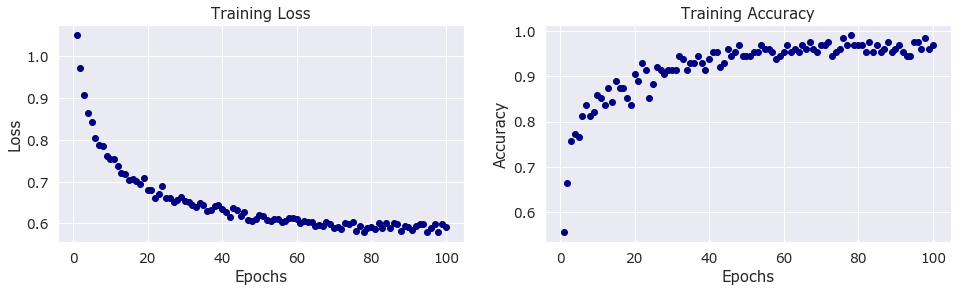

In [19]:
tfu.show_plots(history)

### Evaluating performance of Tensorflow model
Let's evaluate performance of our model on training, cross-validation & test data.

In [20]:
print('Evaluating performance:')
feed_dict_eval = {kp:(1.0)} # NO droput during evaluation!!
loss, acc = tfu.evaluate_model(sess, tf_model, X_train, y_train, feed_dict=feed_dict_eval, batch_size=batch_size)
print('    - Training dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

loss, acc = tfu.evaluate_model(sess, tf_model, X_test, y_test, feed_dict=feed_dict_eval, batch_size=batch_size)
print('    - Test dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

Evaluating performance:
  Evaluating : Batch (8/8) [==============================] -> loss: 0.5741 - acc: 0.9844                                        
    - Training dataset: loss = 0.5741, accuracy = 0.9844
  Evaluating : Batch (2/2) [==============================] -> loss: 0.5816 - acc: 0.9688                                        
    - Test dataset: loss = 0.5816, accuracy = 0.9688


**Observations for Tensorflow Model:**
* We get a `training accuracy = 98.4%` and a `test accuracy = ~97%` with this model.
* Since the difference between training & cross-validation accuracy is not much, we can conclude the thet model is not overfitting the data.

In [21]:
# save the model state & close session
tfu.save_tf_model(sess, base_file_name=TF_MODEL_NAME, model_path=MODEL_SAVE_DIR)
del tf_model
sess.close()

### Making Predictions with the Tensorflow Model
Next we will run predictions with our Tensorflow model & view some random results. 

NOTE: Model structure (graph) & state (parameters) will be loaded from last saved state.

In [22]:
tf.reset_default_graph()
sess = tf.Session()
tf_model, X, y, kp = load_tf_model(sess, base_file_name=TF_MODEL_NAME, model_path=MODEL_SAVE_DIR)
print('Loaded model')
print(tf_model)
print('Loaded placeholders: X = {}, y = {}, kp={}'.format(X, y, kp), flush=True)

INFO:tensorflow:Restoring parameters from ./model_states/tf_IRIS_mlp
Loaded model
{'out': <tf.Tensor 'out:0' shape=(?, 3) dtype=float32>, 'loss': <tf.Tensor 'loss:0' shape=() dtype=float32>, 'train_op': <tf.Operation 'train_op' type=NoOp>, 'correct_prediction': <tf.Tensor 'correct_prediction:0' shape=(?,) dtype=bool>, 'accuracy': <tf.Tensor 'acc:0' shape=() dtype=float32>}
Loaded placeholders: X = Tensor("X:0", shape=(?, 4), dtype=float32), y = Tensor("y:0", shape=(?, 3), dtype=float32), kp=Tensor("keep_prob:0", dtype=float32)


In [23]:
# this is the ground truth (reverse one-hot encode of test data)
y_true = np.argmax(y_test, axis=1)
y_true[:30]

array([2, 2, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 0, 0, 1, 0, 2, 2, 0])

In [24]:
feed_dict_eval = {kp:(1.0)} # NO droput during evaluation!!
predictions = tfu.predict(sess, tf_model, X_test, feed_dict=feed_dict_eval) # no dropouts when running predictions
# reverse one-hot encode the predictions
y_pred = np.argmax(predictions, axis=1)
y_pred[:30]

array([2, 2, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 2, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 0, 0, 1, 0, 2, 2, 0])

In [25]:
# how many mismatches
(y_pred != y_true).sum()

1

In [26]:
# close the Tensorflow session
sess.close()

## Keras Implementation
In this section, we will develop the same model using the Keras API. You will notice immediately that the code written in this section is much less & much cleaner. Keras takes care of most of the details we covered above.

In [27]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
import kr_helper_funcs as kru

# clear the Tensorflow backend to get rid of any spurious graphs
K.clear_session()

In [28]:
def build_keras_model(layer_dims):
    model = Sequential()
    model.add(Dense(layer_dims[1], activation='relu', input_shape=(layer_dims[0],)))
    model.add(Dropout(0.35))
    model.add(Dense(layer_dims[2], activation='relu'))
    model.add(Dropout(0.35))
    # output is softmax
    model.add(Dense(layer_dims[3], activation='softmax'))
    adam = optimizers.Adam(lr=0.001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])
    return model

In [29]:
kr_model = build_keras_model(layer_dims)
print(kr_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 4,675
Trainable params: 4,675
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# train the model
history = kr_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/100
120/120 [==============================] - 0s 3ms/step - loss: 1.0810 - acc: 0.3750
Epoch 2/100
120/120 [==============================] - 0s 244us/step - loss: 0.9144 - acc: 0.6000
Epoch 3/100
120/120 [==============================] - 0s 221us/step - loss: 0.7761 - acc: 0.7667
Epoch 4/100
120/120 [==============================] - 0s 230us/step - loss: 0.6782 - acc: 0.7833
Epoch 5/100
120/120 [==============================] - 0s 225us/step - loss: 0.6057 - acc: 0.8167
Epoch 6/100
120/120 [==============================] - 0s 188us/step - loss: 0.5528 - acc: 0.7833
Epoch 7/100
120/120 [==============================] - 0s 158us/step - loss: 0.4893 - acc: 0.8083
Epoch 8/100
120/120 [==============================] - 0s 146us/step - loss: 0.4477 - acc: 0.8250
Epoch 9/100
120/120 [==============================] - 0s 160us/step - loss: 0.4118 - acc: 0.8250
Epoch 10/100
120/120 [==============================] - 0s 152us/step - loss: 0.3852 - acc: 0.8250
Epoch 11/100
120/120 

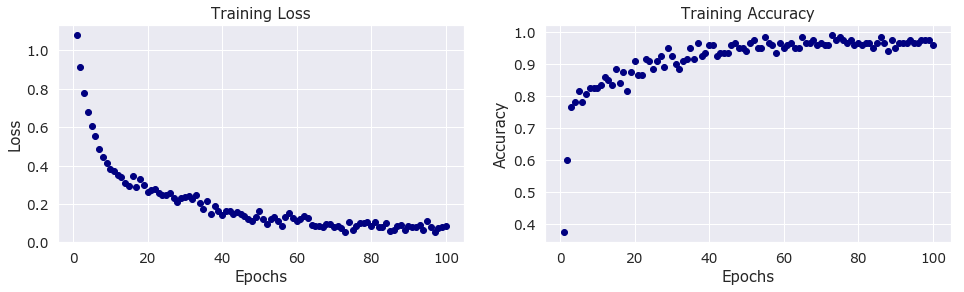

In [31]:
# display plots of loss & accuracies
kru.show_plots(history.history)

In [32]:
# evaluate performance against train/cross-val & test data
print('Evaluating performance of Keras model:')
loss, acc = kr_model.evaluate(X_train, y_train, batch_size=batch_size)
print(' - Training dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

loss, acc = kr_model.evaluate(X_test, y_test, batch_size=batch_size)
print(' - Test dataset: loss = {:.4f}, accuracy = {:.4f}'.format(loss, acc))

Evaluating performance of Keras model:
120/120 [==============================] - 0s 535us/step
 - Training dataset: loss = 0.0502, accuracy = 0.9750
30/30 [==============================] - 0s 108us/step
 - Test dataset: loss = 0.0537, accuracy = 0.9667


**Observations for Keras Model:**
* We get a `training accuracy = 98.3 %` and a `test accuracy = ~97%` with this model. **These are similar to Tensorflow model performance! **
* Since the difference between training & cross-validation accuracy is not much, we can conclude the thet model is not overfitting the data.

### Making Predictions with the Keras Model
Next we will run predictions with our Tensorflow model & view some random results.

In [33]:
# this is the ground truth (reverse one-hot encode of test data)
y_true = np.argmax(y_test, axis=1)
y_true[:30]

array([2, 2, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 0, 0, 1, 0, 2, 2, 0])

In [34]:
predictions = kr_model.predict(X_test)
# reverse one-hot encode the predictions
y_pred = np.argmax(predictions, axis=1)
y_pred[:30]

array([2, 2, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 2, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 0, 0, 1, 0, 2, 2, 0])

In [35]:
# no of mismatches
(y_pred != y_true).sum()

1

# <center> -- END -- </center>